In [28]:
%config IPCompleter.greedy=True

# Reconocimiento de dígitos con KNN

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [29]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/zarthaxx/Desktop/metnum-tp2
-- Configuring done
-- Generating done
-- Build files have

In [1]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/zarthaxx/Desktop/metnum-tp2/notebooks
Python 3.6.9


## Explorando los datos

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [3]:
df_train = df_train[:1000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [4]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((1000, 784), (1000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 8


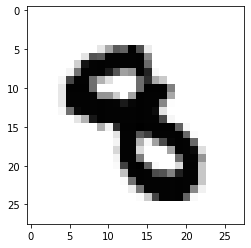

In [5]:
import matplotlib.pyplot as plt

num = 67

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [6]:
df_train["label"].value_counts(normalize=True)

2    0.124
0    0.107
7    0.105
4    0.102
9    0.097
6    0.097
1    0.096
8    0.093
3    0.090
5    0.089
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

## Funciones para utilizar las metaheuristics

In [7]:
import numpy.random as rn

K_FOLD = 5
k_range = (1, 800)
T = 100

In [8]:
def clip_k(k):
    a, b = k_range
    
    return max(a,min(b,int(k)))

In [9]:
def random_start():
    a, b = k_range
    rnd_k = a + (b - a) * rn.random_sample()
    return clip_k(rnd_k)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from scoring import cross_validation as cv, accuracy as acc, recall, precision, f1

def scoring(k):
    clf = KNeighborsClassifier(k)
    accuracy = cv.cross_validate(clf, X, y, f1.f1_score, K_FOLD)
    return accuracy

In [11]:
def random_neighbour(actual_k, fraction=0.0):
    a, b = k_range
    new_k = actual_k
    
    while new_k == actual_k and fraction != 1.0:
        delta = int((b - a) * (0.5-rn.random_sample()) * (1.0-fraction))
        new_k = clip_k(actual_k + delta)
        
    return new_k


In [16]:
import numpy as np

def acceptance_probability(cost, new_cost, temperature):
    if new_cost > cost:
        return 1
    else:
        p = np.exp(- ( cost - new_cost) / temperature)
        return p

In [17]:
def change_temperature(fraction):
    return T*(1-fraction)

In [23]:
from metaheuristics import simulated_annealing as sa

best_state = sa.annealing(random_start,scoring,random_neighbour,acceptance_probability,change_temperature,10,10)

initial: state = 421, score = 0.37514703550922107
#0 Found better solution [k = 239, score = 0.5147675289692868]
#1 Found better solution [k = 1, score = 0.8489753161240066]
Best solution: state = 1, score = 0.8489753161240066


In [70]:
from metaheuristics import random_search as rnd_s

rnd_s.random_search(random_start,random_start,scoring,10,600)

Initiating...
Starting search...
Processing...
Processing...
Processing...
4: Found better solution [k = 125, score: 0.643]
Processing...
Processing...
6: Found better solution [k = 47, score: 0.731]
Processing...
Processing...
Processing...
Processing...
10: Found better solution [k = 17, score: 0.801]
Processing...


17

In [82]:
from metaheuristics import hillclimber_search as hill_s

hill_s.hillclimber_search(random_start,random_neighbour,scoring,10,600)

Initiating...
Starting search...
1: Found better solution [k = 1, score: 0.856]
Processing...
Processing...
Processing...
Processing...
Processing...
Processing...
Processing...
Processing...
Processing...
Processing...


1